<a href="https://colab.research.google.com/github/AndreasGueluekoglu/Machine_Learning_Empfehlungssystem_Filmdaten/blob/master/KNN_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Pakete importieren
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
from google.colab import files
import random
import os
# Dünn besetzte Matrix mit 0en komprimieren
from scipy.sparse import csr_matrix
# KNN - Clusteralgorithmus
from sklearn.neighbors import NearestNeighbors
# Visualisierung anhand mathematischer Darstellungen
import matplotlib.pyplot as plt
# Unscharfe Suche (Klasse von String-Matching Algorithmen)
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from sklearn import datasets, neighbors
from mlxtend.plotting import plot_decision_regions

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Daten Einlesen und Zuordnen

In [ ]:
from google.colab import files
data_to_load = files.upload()

Saving movies.csv to movies.csv
Saving ratings.csv to ratings.csv


In [ ]:
# CSV-Dateien auslesen und zuordnen
moviedata = pd.read_csv('movies.csv', usecols=['movieId', 'title'], sep=',', dtype={'movieId': 'int32', 'title': 'str'})
ratingsdata = pd.read_csv('ratings.csv', usecols=['userId', 'movieId', 'rating'], sep=',', dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

# Ausgabe der ersten fünf Datensätze
moviedata.head(5)

movieId                               title
0        1                    Toy Story (1995)
1        2                      Jumanji (1995)
2        3             Grumpier Old Men (1995)
3        4            Waiting to Exhale (1995)
4        5  Father of the Bride Part II (1995)

In [ ]:
#Ausgabe der ersten fünf Datensätze
ratingsdata.head(5)

userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
4       1       50     5.0

## Visualisierung via Facets

In [ ]:
jsonstr = ratingsdata.to_json(orient='records')
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=jsonstr)
display(HTML(html))

In [ ]:
# Pivot der Ratingsdata-Tabelle, sodass für jeden Film die jeweilige Bewertung aller Nutzer dargestellt wird (Bei Na wird mit 0 aufgefüllt)
moviefeatures = ratingsdata.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)
# Da wir mit 0en auffüllen bietet es sich an, eine dünnbesetzte Matrix zu verwenden (Speicher- Laufzeiteffizienz)
mat_movie_features = csr_matrix(moviefeatures.values)
# Pivot-Tabelle mit allen Filmen und den Bewertungen von jedem Nutzer 
moviefeatures.head()

userId   1    2    3    4    5    6    7    ...  604  605  606  607  608  609  610
movieId                                     ...                                   
1        4.0  0.0  0.0  0.0  4.0  0.0  4.5  ...  3.0  4.0  2.5  4.0  2.5  3.0  5.0
2        0.0  0.0  0.0  0.0  0.0  4.0  0.0  ...  5.0  3.5  0.0  0.0  2.0  0.0  0.0
3        4.0  0.0  0.0  0.0  0.0  5.0  0.0  ...  0.0  0.0  0.0  0.0  2.0  0.0  0.0
4        0.0  0.0  0.0  0.0  0.0  3.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5        0.0  0.0  0.0  0.0  0.0  5.0  0.0  ...  3.0  0.0  0.0  0.0  0.0  0.0  0.0

[5 rows x 610 columns]

In [ ]:
# Anzahl der User und Filme in Ratingsdata (sprich Filme die bewertet wurden)
num_users = len(ratingsdata.userId.unique())
num_moviesRatingsdata = len(ratingsdata.movieId.unique())
print(num_users)

610


In [ ]:
print(num_moviesRatingsdata)

9724


In [ ]:
# Anzahl der Filme in Moviedata (Sprich Filme mit Titeln)
# In Moviedata befinden sich mehr Filme, bei der Differenz handelt es sich jedoch um Filme ohne Bewertung
num_moviesMoviedata = len(moviedata.movieId.unique())
print(num_moviesMoviedata)

9742


In [ ]:
# Anzahl der vergebenen Ratingsstufen (0.5 - 5.0)
df_ratings_cnt_tmp = pd.DataFrame(ratingsdata.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

count
rating       
0.5      1370
1.0      2811
1.5      1791
2.0      7551
2.5      5550
3.0     20047
3.5     13136
4.0     26818
4.5      8551
5.0     13211

In [ ]:
# Das Rating mit dem Wert 0 kommt am häufigsten vor --> Dies ist auf das auffüllen zurückzuführen (0 beschreibt nicht, dass der Film schlecht ist, sondern nicht bewertet wurden (Durch Pivotierung festgelegt))
total_cnt = num_users * num_moviesRatingsdata
rating_zero_cnt = total_cnt - ratingsdata.shape[0]

df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

count
0.0  5830804
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211

In [ ]:
#Log-Normalisierung zur graphischen Darstellung (Plot)
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

count  log_count
0.0  5830804  15.578665
0.5     1370   7.222566
1.0     2811   7.941296
1.5     1791   7.490529
2.0     7551   8.929435
2.5     5550   8.621553
3.0    20047   9.905835
3.5    13136   9.483112
4.0    26818  10.196829
4.5     8551   9.053804
5.0    13211   9.488805

Text(0, 0.5, 'Anzahl der Ratings')

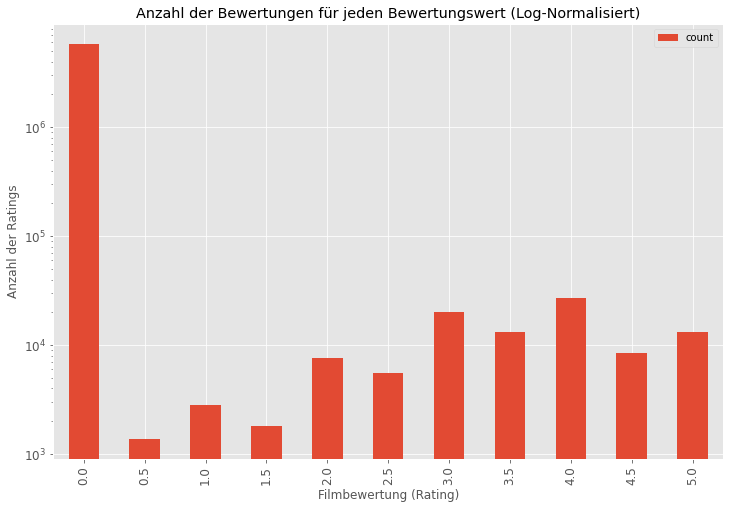

In [ ]:
#Plot der log-normalisierten Anzahl der Ratings
plt.style.use('ggplot')

get_ipython().run_line_magic('matplotlib', 'inline')
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Anzahl der Bewertungen für jeden Bewertungswert (Log-Normalisiert)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("Filmbewertung (Rating)")
ax.set_ylabel("Anzahl der Ratings")


In [ ]:
# Anzahl der Ratings für einen Film
df_movies_cnt = pd.DataFrame(ratingsdata.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

count
movieId       
1          215
2          110
3           52
4            7
5           49

In [ ]:
# Anzahl der Ratings eines Users
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

count
userId       
1         117
2          15
3           6
4          84
5          34

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


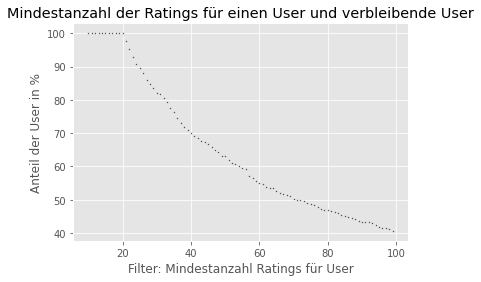

In [ ]:
# Verbliebene User im Verhältnis zu zuvor ungefilterten Usern

x = []
y = []
for i in range(10,100):
  x.append(i)
  y.append(len(ratingsdata.groupby('userId').filter(lambda x: len(x) >= i).userId.unique())/len(ratingsdata.userId.unique()) * 100)
plt.scatter(x, y, s=1, c=(0,0,0), alpha=0.5)
plt.title('Mindestanzahl der Ratings für einen User und verbleibende User')
plt.xlabel('Filter: Mindestanzahl Ratings für User')
plt.ylabel('Anteil der User in %')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


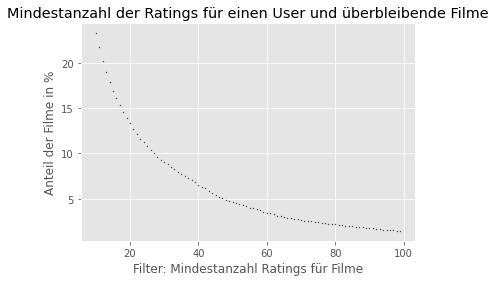

In [ ]:
#Verbliebene Filme im Verhältnis zu zuvor ungefilterten Filmen

x = []
y = []
for i in range(10,100):
  x.append(i)
  y.append(len(ratingsdata.groupby('movieId').filter(lambda x: len(x) >= i).movieId.unique())/len(moviedata.movieId.unique()) * 100)
plt.scatter(x, y, s=1, c=(0,0,0), alpha=0.5)
plt.title('Mindestanzahl der Ratings für einen User und überbleibende Filme')
plt.xlabel('Filter: Mindestanzahl Ratings für Filme')
plt.ylabel('Anteil der Filme in %')
plt.show()

Durch eine Mindestanzahl an Ratings gehen in beiden Fällen sowohl User, als auch Filme verloren. Besonders sensibel reagiert hierbei der Anteil der übrig gebliebenen Filme auf die Vergabe. Daraus lässt sich schlussfolgern, dass ein wesentlicher Großteil der Filme lediglich "wenige" Bewertungen aufweist.


In [ ]:
# Filterung nach Filmen die mind. 50 mal bewertet wurden
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = ratingsdata[ratingsdata.movieId.isin(popular_movies)]
print('Form der ursprünglichen Ratingsdata: ', ratingsdata.shape)
print('Form von Ratingsdata nachdem die unbeliebten Filme wegfallen: ', df_ratings_drop_movies.shape)

Form der ursprünglichen Ratingsdata:  (100836, 3)
Form von Ratingsdata nachdem die unbeliebten Filme wegfallen:  (41360, 3)


In [ ]:
# Filterung der übrigen Filme nach Usern die mind. 50 mal bewertet haben
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('Form der ursprünglichen Ratingsdata: ', ratingsdata.shape)
print('Form von Ratingsdata nachdem die unbeliebten Filme wegfallen: ', df_ratings_drop_movies.shape)
print('Form von Ratingsdata nachdem die unbeliebten Filme und inaktiven User wegfallen: ', df_ratings_drop_users.shape)

Form der ursprünglichen Ratingsdata:  (100836, 3)
Form von Ratingsdata nachdem die unbeliebten Filme wegfallen:  (41360, 3)
Form von Ratingsdata nachdem die unbeliebten Filme und inaktiven User wegfallen:  (32999, 3)


In [ ]:
# Pivot für eine User-Film Matrix mit den übrig gebliebenen Filmen und den jeweiligen Bewertungen aller Nutzer
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
movie_user_mat.head()

userId   1    4    6    7    15   16   17   ...  603  604  605  606  607  608  610
movieId                                     ...                                   
1        4.0  0.0  0.0  4.5  2.5  0.0  4.5  ...  4.0  3.0  4.0  2.5  4.0  2.5  5.0
2        0.0  0.0  4.0  0.0  0.0  0.0  0.0  ...  0.0  5.0  3.5  0.0  0.0  2.0  0.0
3        4.0  0.0  5.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  2.0  0.0
6        4.0  0.0  4.0  0.0  0.0  0.0  0.0  ...  4.0  3.0  0.0  0.0  0.0  0.0  5.0
7        0.0  0.0  4.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  2.5  0.0  0.0  0.0

[5 rows x 268 columns]

In [ ]:
#Zuordnung der Filmtitel für jeden Film durch Moviedata (Filmtitel mappen für jede movieID)
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(moviedata.set_index('movieId').loc[movie_user_mat.index].title))
}
print(movie_to_idx)

{'Toy Story (1995)': 0, 'Jumanji (1995)': 1, 'Grumpier Old Men (1995)': 2, 'Heat (1995)': 3, 'Sabrina (1995)': 4, 'GoldenEye (1995)': 5, 'American President, The (1995)': 6, 'Casino (1995)': 7, 'Sense and Sensibility (1995)': 8, 'Ace Ventura: When Nature Calls (1995)': 9, 'Get Shorty (1995)': 10, 'Leaving Las Vegas (1995)': 11, 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)': 12, 'Babe (1995)': 13, 'Dead Man Walking (1995)': 14, 'Clueless (1995)': 15, 'Seven (a.k.a. Se7en) (1995)': 16, 'Pocahontas (1995)': 17, 'Usual Suspects, The (1995)': 18, "Mr. Holland's Opus (1995)": 19, 'From Dusk Till Dawn (1996)': 20, 'Broken Arrow (1996)': 21, 'Happy Gilmore (1996)': 22, 'Braveheart (1995)': 23, 'Taxi Driver (1976)': 24, 'Birdcage, The (1996)': 25, 'Bad Boys (1995)': 26, 'Apollo 13 (1995)': 27, 'Batman Forever (1995)': 28, 'Casper (1995)': 29, 'Congo (1995)': 30, 'Crimson Tide (1995)': 31, 'Desperado (1995)': 32, 'Die Hard: With a Vengeance (1995)': 33, 'First Knight (1995)': 34, 'Johnny Mnemonic 

In [ ]:
# Transformiert die Matrix in eine dünnbesetzte Matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [ ]:
movie_user_mat_sparse

<450x268 sparse matrix of type '<class 'numpy.float32'>'
	with 32999 stored elements in Compressed Sparse Row format>

In [ ]:
# Objekterstellung für die NearestNeighbors Class (KNN-Algorithmus)
# Kosinus-Ähnlichkeit als Distanzmaß: Maß für die Ähnlichkeit zweier Vektoren. Dabei wird der Kosinus des Winkels zwischen beiden Vektoren bestimmt
# Anzahl der Neighbours k wird durch Annäherung ermittelt. Startwert liegt bei der Wurzel von n, wobei n die Anzahl der Datensätze ist (iteratives Vorgehen)
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# Zu trainierendes Model definieren
model_knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [ ]:
# Funktion für unscharfe Suche - Bestimmte Zeichenkette (Filmtitel) in einem Text oder Zeichenkette (Map) matchen anhand fuzzy ratio
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data
    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True
    Return
    ------
    index des nähesten Matches
    """
    match_tuple = []
    # Match/Übereinstimmung wiedergeben
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # Sortieren
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Leider konnten wir Ihren Film in unserer Datenbank nicht finden :(')
        return
    if verbose:
        print('Folgende Filme können wir Ihnen anbieten: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

In [ ]:
# Funktion zur Durchführung der Filmempfehlung  (n am meisten übereinstimmende Filme)
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    Parameters
    ----------
    model_knn: sklearn model, knn model
    data: movie-user matrix
    mapper: dict, map movie title name to index of the movie in data
    fav_movie: str, name of user input movie
    n_recommendations: int, top n recommendations
    Return
    ------
    Liste der am meisten übereinstimmenden Filme entlang der Eingabe
    """
    # Model trainieren
    model_knn.fit(data)
    # Index des ausgewählten Filmes
    print('Eigegebener Film:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    
    print('Der Empfehldienst beginnt mit der Arbeit')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    
    raw_recommends =         sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # Daten in der Liste umkehren, da die Distanzen absteigend sortiert sind
    reversed_raw_recommends = []
    for i in range (len(raw_recommends)):
      reversed_raw_recommends.append(raw_recommends[-(i+1)])
    # Mapper umkehren
    reverse_mapper = {v: k for k, v in mapper.items()}
    # Ausgabe der Empfehlungen
    print('Empfehlungen für {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(reversed_raw_recommends):
        print('{0}: {1}, mit einer Distanz von {2}'.format(i+1, reverse_mapper[idx], dist))


In [ ]:
# Leerzeichen nach dem Filmnamen beachten!
my_favorite = 'Back to the Future Part II (1989) '
make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

Eigegebener Film: Back to the Future Part II (1989) 
Folgende Filme können wir Ihnen anbieten: ['Back to the Future Part II (1989)', 'Back to the Future Part III (1990)', 'Back to the Future (1985)']

Der Empfehldienst beginnt mit der Arbeit
......

Empfehlungen für Back to the Future Part II (1989) :
1: Back to the Future Part III (1990), mit einer Distanz von 0.218889057636261
2: Back to the Future (1985), mit einer Distanz von 0.2978448271751404
3: Indiana Jones and the Temple of Doom (1984), mit einer Distanz von 0.33741748332977295
4: Star Wars: Episode VI - Return of the Jedi (1983), mit einer Distanz von 0.3668050169944763
5: Ghostbusters (a.k.a. Ghost Busters) (1984), mit einer Distanz von 0.37827980518341064
6: Minority Report (2002), mit einer Distanz von 0.38248497247695923
7: Star Wars: Episode V - The Empire Strikes Back (1980), mit einer Distanz von 0.3856540322303772
8: Star Wars: Episode IV - A New Hope (1977), mit einer Distanz von 0.3960599899291992
9: Star Wars: Epis

In [ ]:
len(movie_to_idx)

450

In [ ]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
%matplotlib inline
 
scores = []
k_range = range(1,100)
for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(learnset_data, learnset_labels) # keine Aufteilung zwischen Trainings- und Testdaten
    actual = knn.predict(testset_data)
    scores.append(metrics.accuracy_score(testset_labels, actual))

plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.plot(k_range, scores)

NameError: ignored